# 🏭 **Combined Cycle Power Plant Dataset (CCPP)**

---

### **● 📋 Data Overview**

A Combined Cycle Power Plant (CCPP) is composed of gas turbines (GT), steam turbines (ST) and heat recovery steam generators (HRSG) in single thermodynamic cycle. The gas turbine's exhaust heat generates steam which drive the steam turbine, increasing overall efficiency. The exhaust vacuum (V) is a critical parameter of the steam turbine's condenser system. Meanwhile, the three ambient variables temperature, pressure and relative humidity primarily affect the gas turbine's performance. The dataset records collected from a Combined Cycle Power Plant over 6 years (2006-2011), when the power plant was set to work with full load.

### ⏱️Features consist of hourly average variables:

- ***Ambient Temperature (AT):*** in the range 1.81°C and 37.11°C.

- ***Ambient Pressure (AP):*** in the range 992.89-1033.30 milibar.

- ***Relative Humidity (RH):*** in the range 25.56% to 100.16%.

- ***Exhaust Vacuum (V):*** in teh range 25.36-81.56 cm Hg.

- ***Net hourly electrical energy Target (PE):*** 420.26-495.76 MW.

The averages are taken from various sensors located around the plant that record the ambient variables every second. The variables are given without normalization.
#### **● Objective**
To predict the net hourly electricity energy output pf the plant.
#### **● Attribute Information**
|                            |                   |
|----------------------------|-------------------|
| **Data pints/Measurments** | 9568              |
| **Features**               | 4                 |
| **Target**                 | Electrical Output |

| Feature | Description                              |
|---------|------------------------------------------|
| **AT**  | Ambient Temperature (℃)                  |
| **AP**  | Ambient Pressure (milibar)               |
| **RH**  | Relative Humidity (%)                    |
| **V**   | Exhaust Vacuum (cm Hg)                   |
| **PE**  | Net hourly electrical energy output (MW) |

# **» Starting the system Pipeline as following Steps :**
## **🔍 Step 1: 🛠️ Production Environment Setup**


In [1]:
import warnings                             # Suppress warnings for cleaner outputs
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns                       # Advanced visualization (correlation matrix)
import joblib                               # Save/load large models and preprocessing objects
import json                                 # Handle JSON configs and outputs
from datetime import datetime               # Timestamping for logs
import os                                   # File system operations
import time                                 # Time tracking for experiments
from IPython.display import display

#====================================================================================================================================================

# 🧰 Scikitlearn libraries - expanded for advanced ML workflows
from sklearn.model_selection import (
       train_test_split,                   # Split data into train/test sets
       cross_val_score,                    # Cross-validation scoring
       GridSearchCV,                       # Hyperparameter tuning (grid search)
       RandomizedSearchCV                 # Hyperparameter tuning (randomized search)
)
from sklearn.preprocessing import (
       StandardScaler,                     # Feature scaling (zero-mean, unit variance)
       RobustScaler,                       # Scaling robust to outliers
)

#====================================================================================================================================================

# Build modular pipelines
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import (
     f_regression,                        # Scoring function for regression (measures that relationship using a statistical F-test between each feature and the target)
     SelectKBest,                          # Univariate feature selection (selects the top K input features that have the strongest individual relationship with the target variable)
     RFE                                   # Recursive feature elimination (repeatedly trains a model and removes the least important features step by step until only the best ones remain)
)

#====================================================================================================================================================

from sklearn.linear_model import (
      LinearRegression,
      Lasso,                             #L1-regularized
      Ridge,                             #L2-regularized
      ElasticNet                        # Combination of L1 and L2 regularization
)

#====================================================================================================================================================

from sklearn.ensemble import (
    RandomForestRegressor,              # Ensemble of decision trees
    GradientBoostingRegressor,          # Boosted trees for regression
    VotingRegressor                     # Combine multiple regressors
)

#====================================================================================================================================================

from sklearn.svm import SVR
from sklearn.metrics import (
     mean_squared_error,
     r2_score,
     mean_absolute_error
)

#====================================================================================================================================================

from sklearn.inspection import (
    permutation_importance,       # Feature importance (measures how much model performance drops when the values of one feature are randomly shuffled)
    PartialDependenceDisplay      # Partial dependence plots (shows how the predicted output changes when one (or two) features vary, while others are averaged out)
)

#====================================================================================================================================================

# 🧪 Advanced model tracking with MLflow
import mlflow                  # Experiment tracking
import mlflow.sklearn          # Log sklearn models
from mlflow.models.signature import infer_signature  # Auto-capture input/output schema (data shape and type) for reproducible deployment

#====================================================================================================================================================


## **🔍 Step 2: 🎛️ Configuration & Reproducibility**

Before we start modeling, it’s crucial to **establish reproducible and scalable experiment settings**. This ensures that results are consistent, experiments are traceable, and your workflow is production-ready.

### ◆ Key Components:

1. **Reproducibility**
   - Ensures that every run produces the same train/test splits, random sampling, and model results.
   - Reserving the data for test and final evaluation, and another portion for validation and hyperparameter tuning.
   - Use 5-fold cross-validation to evaluate models robustly.
   - Utilizes all available CPU cores to speed up computations.
   <br>
2. **Organized Project Structure**
   - Store all trained models in a dedicated folder.
   - Save all MLflow experiment logs, metrics, and artifacts in a centralized location.
   - os ensure directories exist, preventing file errors during training or logging.
   <br>
3. **MLflow Experiment Tracking**
   - Point MLflow to the experiment folder.
   - Create a named experiment for thE project.
   - This allows you to **log models, metrics, and hyperparameters**, enabling easy comparison across experiments.


In [2]:
class Config:
    # Reproducibility - Critical for production!
    RANDOM_STATE = 42
    TEST_SIZE = 0.15
    VAL_SIZE = 0.15
    CV_FOLDS = 5
    N_JOBS = -1
    # Model directories - Organized project structure
    MODEL_DIR = "../models"
    EXPERIMENT_DIR = "../experiments"
    # Create directories if they don't exist
    os.makedirs(MODEL_DIR, exist_ok=True)
    os.makedirs(EXPERIMENT_DIR, exist_ok=True)
config = Config()

#====================================================================================================================================================
# Initialize MLflow for experiment tracking
mlflow.set_tracking_uri(f"file:///{os.path.abspath(config.EXPERIMENT_DIR)}") #adding additional "/" to "file://" fixed the error raised
experiment_name = 'power_plant'
mlflow.set_experiment(experiment_name) # Activates that experiment so every run is logged

<Experiment: artifact_location=('file:///C:\\Users\\MOHANAD\\SAIR\\SAIR_Courses\\1_Regression\\Regression '
 'Capstone Projects\\MohanadAhmed (Mo .A)\\experiments/545306358353857481'), creation_time=1767937940131, experiment_id='545306358353857481', last_update_time=1767937940131, lifecycle_stage='active', name='power_plant', tags={}>

## **🔍 Step 3: 📋 Loading the dataset from Local path**

In [4]:
df = pd.read_csv("../Data/Power Plant Data.csv")
X = df.drop('PE', axis=1)
Y = df['PE']
print(f'Dataset shape: {df.shape}')
print(f'Dataset features: {df.columns}')
df.head(15)

Dataset shape: (9568, 5)
Dataset features: Index(['AT', 'V', 'AP', 'RH', 'PE'], dtype='object')


,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90
5,26.27,59.44,1012.23,58.77,443.67
6,15.89,43.96,1014.02,75.24,467.35
7,9.48,44.71,1019.12,66.43,478.42
8,14.64,45.00,1021.78,41.25,475.98
9,11.74,43.56,1015.14,70.72,477.50


## 🔍 Step 4: Exploratory Data Analysis (EDA) - Understanding our data

- Check for missing values
- Understand distributions
- Detect outliers
- Explore relationships between features (Correlation matrix)

In [5]:
from IPython.display import display
display(df.describe())   # Info and Statistical Summary
print("-" * 70)
print(f'⚙️ Missing Values check: \n{df.isnull().sum()}')    # Check Missing Values
print("-" * 70)
print(f'⚙️ Data types: \n{df.dtypes}')     # Data types check

,AT,V,AP,RH,PE
count,9568.000000,9568.000000,9568.000000,9568.000000,9568.000000
mean,19.651231,54.305804,1013.259078,73.308978,454.365009
std,7.452473,12.707893,5.938784,14.600269,17.066995
min,1.810000,25.360000,992.890000,25.560000,420.260000
25%,13.510000,41.740000,1009.100000,63.327500,439.750000
50%,20.345000,52.080000,1012.940000,74.975000,451.550000
75%,25.720000,66.540000,1017.260000,84.830000,468.430000
max,37.110000,81.560000,1033.300000,100.160000,495.760000


----------------------------------------------------------------------
⚙️ Missing Values check: 
AT    0
V     0
AP    0
RH    0
PE    0
dtype: int64
----------------------------------------------------------------------
⚙️ Data types: 
AT    float64
V     float64
AP    float64
RH    float64
PE    float64
dtype: object


# Distribution Analysis

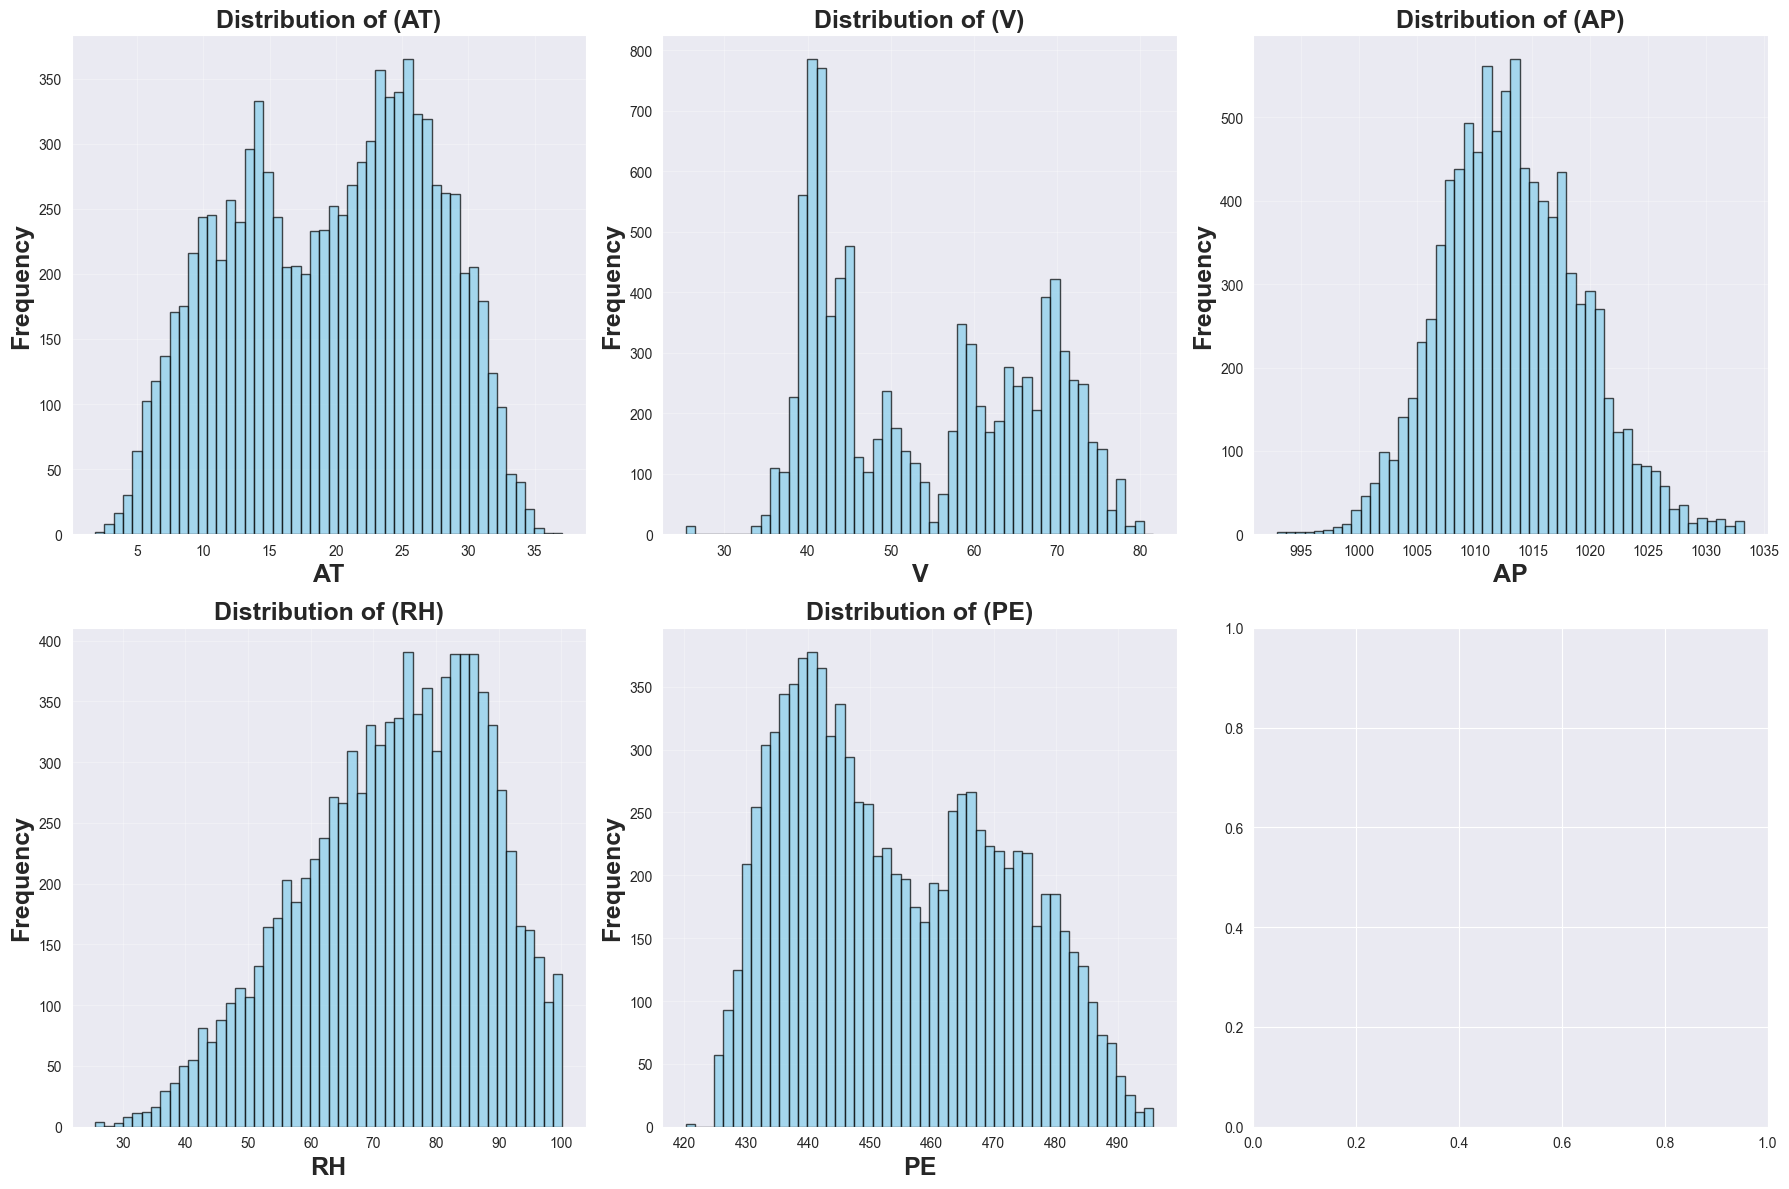

In [6]:
# Visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for idx, col in enumerate(df.columns):
    axes[idx].hist(df[col], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'Distribution of ({col})', fontsize=18, fontweight='bold')
    axes[idx].set_xlabel(col, fontsize=18, fontweight='bold')
    axes[idx].set_ylabel('Frequency', fontsize=18, fontweight='bold')
    axes[idx].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

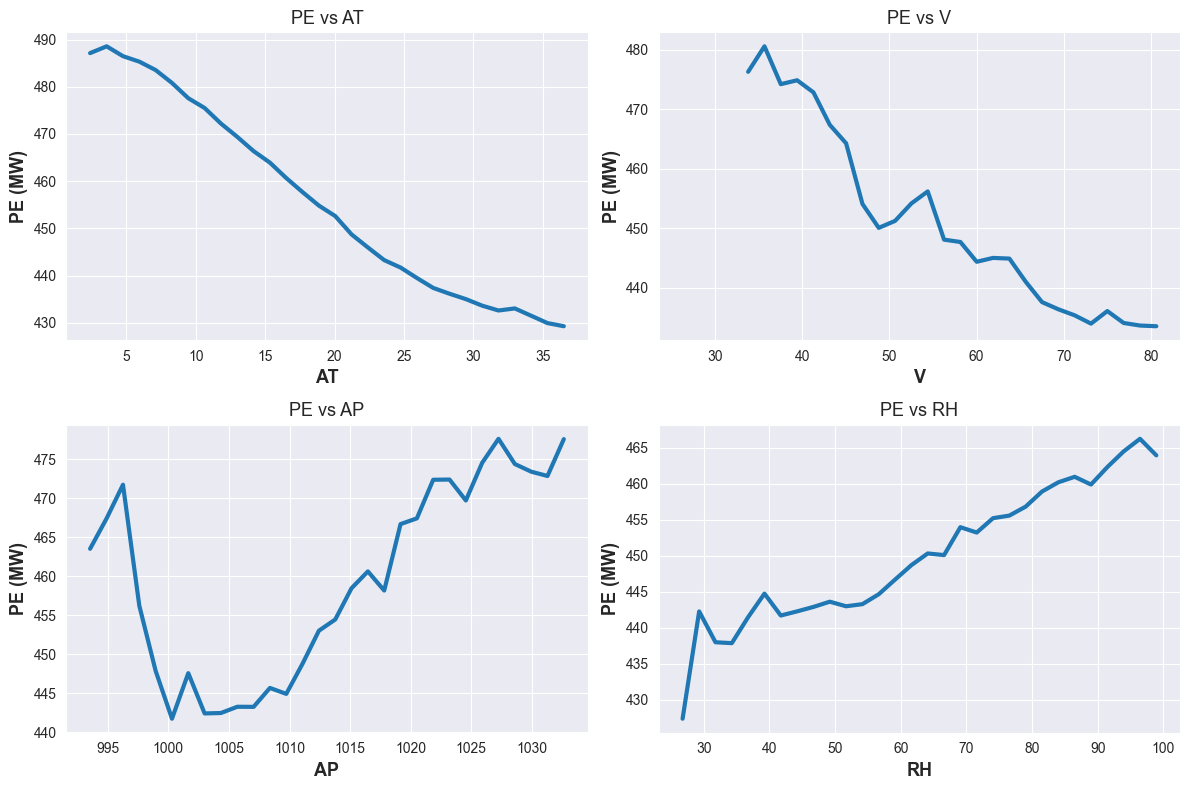

In [28]:
# the relationship between target and each feature
feature_names = ["AT", "V", "AP", "RH"]

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.ravel()
bins = 30                                             # number of bins (controls smoothness)
for i, feature in enumerate(feature_names):
    df["bin"] = pd.cut(df[feature], bins=bins)        # Bin the feature
    grouped = df.groupby("bin")["PE"].mean()          # Mean PE per bin
    x = [interval.mid for interval in grouped.index]  # Bin centers
    y = grouped.values
    axes[i].plot(x, y, linewidth=3)
    axes[i].set_xlabel(feature, fontsize=13, fontweight='bold')
    axes[i].set_ylabel("PE (MW)", fontsize=13, fontweight='bold')
    axes[i].set_title(f"PE vs {feature}", fontsize=13)
    axes[i].grid(True)

plt.tight_layout()
plt.show()

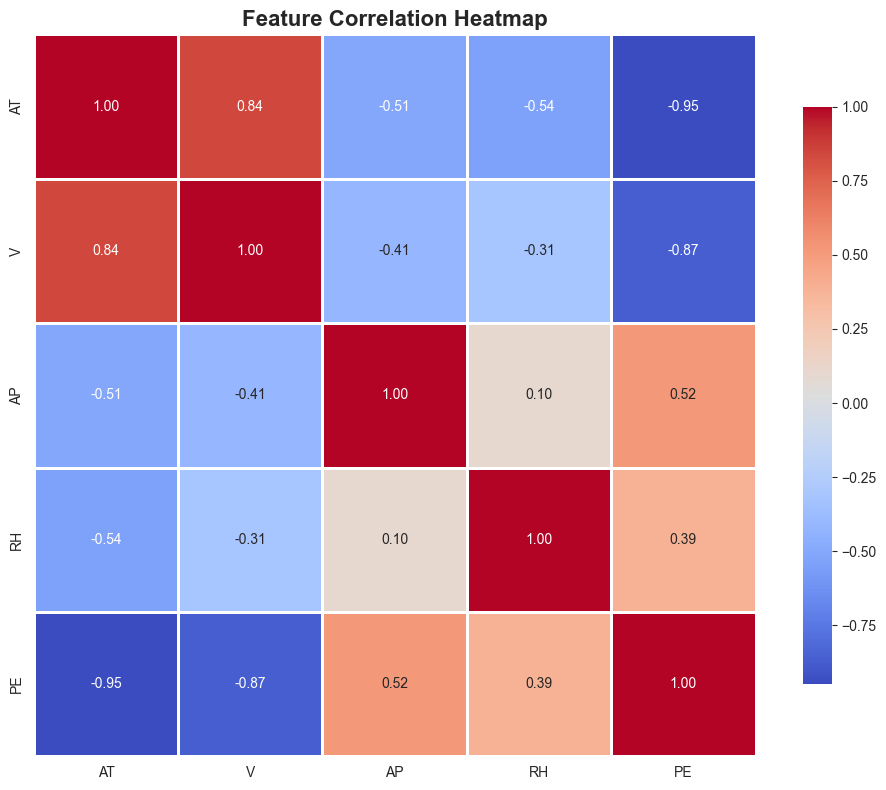


🎯 FEATURES RANKED BY CORRELATION WITH PE
AP                0.5184
RH                0.3898
V                -0.8698
AT               -0.9481


In [8]:
# Correlation matrix
correlation_matrix = df.select_dtypes(include="number").corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Heatmap', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Feature importance ranking
print("\n" + "=" * 70)
print("🎯 FEATURES RANKED BY CORRELATION WITH PE")
print("=" * 70)
correlations = correlation_matrix['PE'].drop('PE').sort_values(ascending=False)
for feature, corr in correlations.items():
    print(f"{feature:<15} {corr:>8.4f}")

## 🔍 Step 5: Data Preprocessing & Feature Engineering
### 🧭 Outlier Handling with IQR

For each feature:

1. Calculate **Q1 (25th percentile)** and **Q3 (75th percentile)**.
2. Compute **IQR = Q3 − Q1**.
3. Define:
   $$
   \text{Lower Bound} = Q1 - 1.5 \times IQR
   \quad
   \text{Upper Bound} = Q3 + 1.5 \times IQR
   $$
4. Clip any values outside this range to make the distribution **more stable**.

### 🧱 Implementation

In [10]:
from sklearn.base import BaseEstimator, TransformerMixin
# NEW: Outlier Handler for Robust Models
class OutlierHandler(BaseEstimator, TransformerMixin):
    """Clip extreme values using IQR method (robust). Works on DataFrames."""

    def __init__(self, factor=1.5):
        self.factor = factor
        self.lower_bounds_ = None
        self.upper_bounds_ = None
        self.feature_names_ = None

    def fit(self, X, y=None):
        if isinstance(X, pd.DataFrame):
            X_values = X.values
            self.feature_names_ = X.columns
        else:
            X_values = X
            self.feature_names_ = [f"f{i}" for i in range(X.shape[1])]

        self.lower_bounds_ = []
        self.upper_bounds_ = []

        for i in range(X_values.shape[1]):
            Q1 = np.percentile(X_values[:, i], 25)
            Q3 = np.percentile(X_values[:, i], 75)
            IQR = Q3 - Q1
            self.lower_bounds_.append(Q1 - self.factor * IQR)
            self.upper_bounds_.append(Q3 + self.factor * IQR)

        return self

    def transform(self, X):
        if isinstance(X, pd.DataFrame):
            X_values = X.values.copy()
        else:
            X_values = X.copy()

        for i in range(X_values.shape[1]):
            X_values[:, i] = np.clip(X_values[:, i],
                                     self.lower_bounds_[i],
                                     self.upper_bounds_[i])

        # Return as DataFrame to keep column names
        return pd.DataFrame(X_values, columns=self.feature_names_)

## 🔍 Step 6: 🏗️ Building Preprocessing Pipeline

We’ve now developed and tested each **individual component** of our preprocessing workflow:

1. 🧠 **`SimpleFeatureEngineer`**
2. 🧹 **`OutlierHandler`** → detects and **clips extreme values** using the IQR method for robust statistics.
3. 📏 **`RobustScaler`** → scales features in a way that’s **less sensitive to outliers** compared to `StandardScaler`.

### 🧱 Implementation

In [12]:
# Create comprehensive preprocessing pipeline
preprocessor = Pipeline([
    ('outlier_handler', OutlierHandler(factor=1.5)),  # Handle outliers
    ('scaler', RobustScaler())  # Robust to outliers (better than StandardScaler)
])

# Apply preprocessing pipeline
print("🔄 Applying preprocessing pipeline...")
X_processed = preprocessor.fit_transform(X, y)

print("✅ ADVANCED PREPROCESSING PIPELINE BUILT!")
print(f"📊 Processed data shape: {X_processed.shape}")

🔄 Applying preprocessing pipeline...
✅ ADVANCED PREPROCESSING PIPELINE BUILT!
📊 Processed data shape: (9568, 4)


## 🔍 Step 7: 🧪 Smarter Data Splitting: Train / Validation / Test Split

* 🧠 **Train set** → Used to train the model.
* 🧪 **Validation set** → Used to tune hyperparameters, early stopping, and model selection.
* 🧭 **Test set** → Kept **completely unseen** until the very end for final evaluation.

### 🧱 Implementation:

In [17]:
# Improved data splitting with validation set
X_temp, X_test, Y_temp, Y_test = train_test_split(
    X_processed, Y, test_size=config.TEST_SIZE, random_state=config.RANDOM_STATE
)

X_train, X_val, Y_train, Y_val = train_test_split(
    X_temp, Y_temp, test_size=config.VAL_SIZE, random_state=config.RANDOM_STATE
)

print(f"• Training: {X_train.shape[0]:,} samples (model learning)")
print(f"• Validation: {X_val.shape[0]:,} samples (hyperparameter tuning)")
print(f"• Test: {X_test.shape[0]:,} samples (final evaluation - NEVER TOUCHED until end)")

• Training: 6,912 samples (model learning)
• Validation: 1,220 samples (hyperparameter tuning)
• Test: 1,436 samples (final evaluation - NEVER TOUCHED until end)


## 🔍 Step 8: 🧠 Expanding Our Model Arsenal: From Basics to Advanced
#### - Introducing Advanced Models:

| Model Name                     | Type                  | Why We Add It 🧭                                                    |
| ------------------------------ | --------------------- | ------------------------------------------------------------------- |
| `LinearRegression`             | Linear Baseline       | A clean baseline — interpretable and fast.                          |
| `Ridge Regression`             | Regularized Linear    | Controls overfitting with L2 regularization.                        |
| `Lasso Regression`             | Regularized Linear    | Performs **feature selection** via L1 penalty.                      |
| `ElasticNet` 🆕                | Hybrid Regularization | Combines L1 + L2 — more flexible for correlated features.           |
| `RandomForestRegressor` 🆕     | Tree Ensemble         | Handles nonlinearities & interactions without feature engineering.  |
| `GradientBoostingRegressor` 🆕 | Boosting Ensemble     | Learns sequentially, improving weak learners over time.             |
| `Support Vector Regression` 🆕 | Kernel Method         | Captures complex relationships using kernel tricks.                 |
| `VotingRegressor` 🆕           | Ensemble Strategy     | Combines multiple models for **stronger, more stable performance**. |

### 🧱 Implementation

In [18]:
# define advanced models - Expanded from previous work
advanced_models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(random_state=config.RANDOM_STATE),
    'Lasso Regression': Lasso(random_state=config.RANDOM_STATE),
    'ElasticNet': ElasticNet(random_state=config.RANDOM_STATE),  # NEW: Combines L1 + L2
    'Random Forest': RandomForestRegressor(random_state=config.RANDOM_STATE, n_jobs=config.N_JOBS),
    'Gradient Boosting': GradientBoostingRegressor(random_state=config.RANDOM_STATE),  # NEW: Sequential learning
    'Support Vector Regression': SVR(),  # NEW: Different approach
}

# NEW: Voting Ensemble - Combines multiple models
voting_ensemble = VotingRegressor([
    ('ridge', Ridge(random_state=config.RANDOM_STATE)),
    ('rf', RandomForestRegressor(random_state=config.RANDOM_STATE, n_jobs=config.N_JOBS)),
    ('gb', GradientBoostingRegressor(random_state=config.RANDOM_STATE))
])

advanced_models['Voting Ensemble'] = voting_ensemble

print(f"\n🎯 MODEL PORTFOLIO ({len(advanced_models)} models):")


🎯 MODEL PORTFOLIO (8 models):


## 🔍 Step 9: 🚀 Building the full advanced model training, evaluation, and logging with mlflow (All-in-One)

This implementation runs the **entire model evaluation workflow in a single function**:

1. **Train the model** → records training time.
2. **Evaluate on training and validation sets** → computes RMSE, R², MAE, and overfitting gap.
3. **Cross-validation** → estimates model stability and performance variability across folds.
4. **MLflow logging** → automatically logs hyperparameters, metrics, and saves the model artifact.
5. **Loop over multiple models** → trains, evaluates, and tracks all models in one go, reporting **validation R², cross-validation mean ± std, and overfitting warnings**.


In [19]:
def evaluate_model_advanced(model, X_train, X_val, Y_train, Y_val, model_name):
    """Comprehensive model evaluation with MLflow tracking"""

    # Start MLflow run for experiment tracking
    with mlflow.start_run(run_name=model_name):
        # Train model with timing
        start_time = time.time()
        model.fit(X_train, Y_train)
        training_time = time.time() - start_time

        # Predictions on both sets
        Y_train_pred = model.predict(X_train)
        Y_val_pred = model.predict(X_val)

        # Calculate comprehensive metrics
        metrics = {
            'train_rmse': np.sqrt(mean_squared_error(Y_train, Y_train_pred)),
            'val_rmse': np.sqrt(mean_squared_error(Y_val, Y_val_pred)),
            'train_r2': r2_score(Y_train, Y_train_pred),
            'val_r2': r2_score(Y_val, Y_val_pred),
            'train_mae': mean_absolute_error(Y_train, Y_train_pred),
            'val_mae': mean_absolute_error(Y_val, Y_val_pred),
            'training_time': training_time,
            'overfitting_gap': r2_score(Y_train, Y_train_pred) - r2_score(Y_val, Y_val_pred)
        }

        # AUTOMATIC TRACKING with MLflow
        mlflow.log_params(model.get_params())  # Log hyperparameters
        mlflow.log_metrics({k: v for k, v in metrics.items() if k != 'training_time'})
        mlflow.sklearn.log_model(model, "model")  # Save model artifact

        # Cross-validation for robust performance estimate
        cv_scores = cross_val_score(model, X_train, Y_train,
                                  cv=config.CV_FOLDS, scoring='r2', n_jobs=config.N_JOBS)
        metrics['cv_r2_mean'] = cv_scores.mean()
        metrics['cv_r2_std'] = cv_scores.std()

        mlflow.log_metrics({
            'cv_r2_mean': metrics['cv_r2_mean'],
            'cv_r2_std': metrics['cv_r2_std']
        })

        return metrics, model

print("🚀 STARTING ADVANCED MODEL EVALUATION...")
print("Each model is being trained, evaluated, and tracked in MLflow")

results = {}
trained_models = {}

for name, model in advanced_models.items():
    print(f"\n🔧 Training {name}...")
    metrics, trained_model = evaluate_model_advanced(
        model, X_train, X_val, Y_train, Y_val, name
    )
    results[name] = metrics
    trained_models[name] = trained_model

    # Progress reporting
    overfitting_indicator = "⚠️" if metrics['overfitting_gap'] > 0.1 else "✅"
    print(f"✅ {name:20} | Val R²: {metrics['val_r2']:.4f} | "
          f"CV R²: {metrics['cv_r2_mean']:.4f} ± {metrics['cv_r2_std']:.4f} "
          f"{overfitting_indicator}")

print(f"\n📈 All models trained and tracked in MLflow!")
print(f"💡 Check MLflow UI: mlflow ui --backend-store-uri {config.EXPERIMENT_DIR}")

🚀 STARTING ADVANCED MODEL EVALUATION...
Each model is being trained, evaluated, and tracked in MLflow

🔧 Training Linear Regression...


2026/01/09 15:06:32 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/09 15:06:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/09 15:06:39 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✅ Linear Regression    | Val R²: 0.9331 | CV R²: 0.9278 ± 0.0037 ✅

🔧 Training Ridge Regression...


2026/01/09 15:06:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/09 15:06:45 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✅ Ridge Regression     | Val R²: 0.9331 | CV R²: 0.9278 ± 0.0037 ✅

🔧 Training Lasso Regression...


2026/01/09 15:06:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2026/01/09 15:06:50 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✅ Lasso Regression     | Val R²: 0.9058 | CV R²: 0.9024 ± 0.0026 ✅

🔧 Training ElasticNet...


2026/01/09 15:06:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ ElasticNet           | Val R²: 0.7107 | CV R²: 0.7214 ± 0.0046 ✅

🔧 Training Random Forest...


2026/01/09 15:06:54 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/09 15:06:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Random Forest        | Val R²: 0.9620 | CV R²: 0.9574 ± 0.0045 ✅

🔧 Training Gradient Boosting...


2026/01/09 15:07:01 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/09 15:07:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Gradient Boosting    | Val R²: 0.9497 | CV R²: 0.9468 ± 0.0052 ✅

🔧 Training Support Vector Regression...


2026/01/09 15:07:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/09 15:07:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Support Vector Regression | Val R²: 0.9440 | CV R²: 0.9379 ± 0.0048 ✅

🔧 Training Voting Ensemble...


2026/01/09 15:07:19 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/09 15:07:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Voting Ensemble      | Val R²: 0.9547 | CV R²: 0.9509 ± 0.0046 ✅

📈 All models trained and tracked in MLflow!
💡 Check MLflow UI: mlflow ui --backend-store-uri ../experiments


## 🔍 Step 10: 📊 Models Comparison & Visualization

- First, we convert the `results` dictionary into a readable table.
- Then, we create simple plots for key metrics to help interpret model performance:

1. **Validation R²** → Higher is better ✅
2. **Validation RMSE** → Lower is better ✅
3. **Overfitting Gap** → Closer to 0 is better ⚖️

📊 Model comparison table:


,Model,val_r2,val_rmse,val_mae,overfitting_gap,cv_r2_mean
0,Linear Regression,0.933113,4.509178,3.568548,-0.005186,0.927820
1,Ridge Regression,0.933092,4.509888,3.569550,-0.005166,0.927820
2,Lasso Regression,0.905757,5.352420,4.310786,-0.003239,0.902352
3,ElasticNet,0.710728,9.377340,7.784148,0.011062,0.721448
4,Random Forest,0.962042,3.396846,2.407439,0.032270,0.957401
5,Gradient Boosting,0.949727,3.909260,2.952568,0.003023,0.946779
6,Support Vector Regression,0.943995,4.126101,3.099899,-0.004308,0.937880
7,Voting Ensemble,0.954693,3.711150,2.788108,0.013924,0.950878


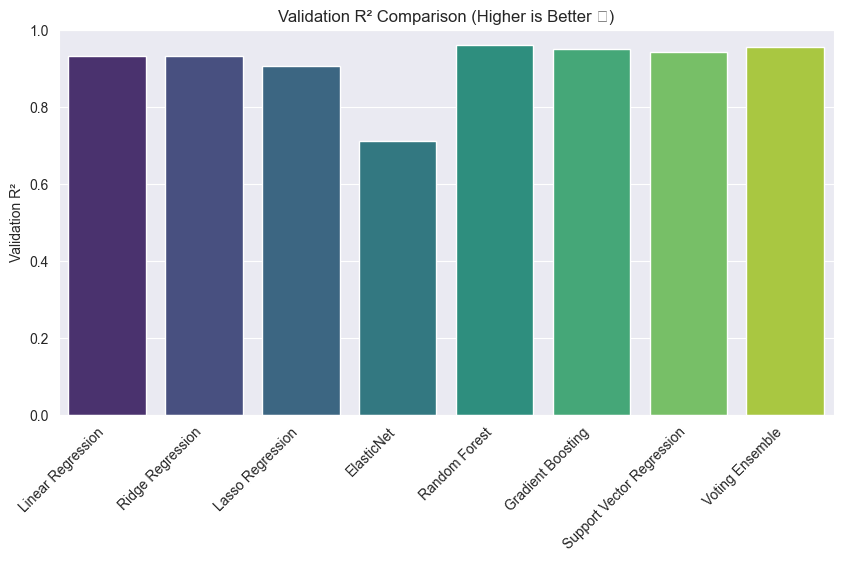

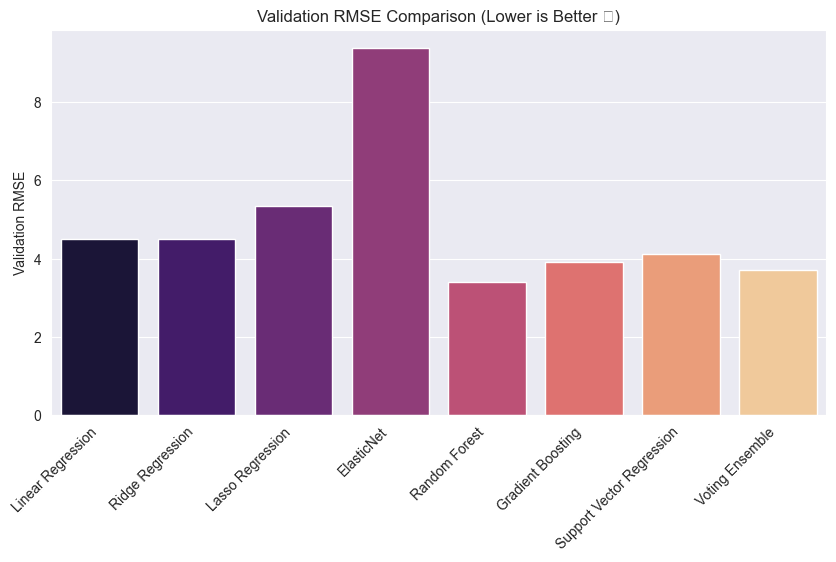

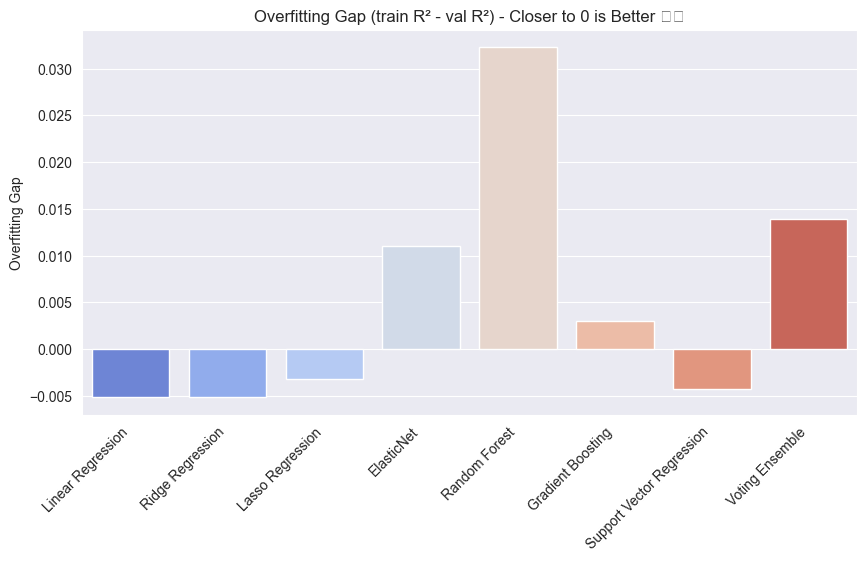

In [20]:
# ===========================
# 1️⃣ Convert results dict to DataFrame
# ===========================
metrics_df = pd.DataFrame(results).T  # transpose so models are rows
metrics_df = metrics_df[['val_r2', 'val_rmse', 'val_mae', 'overfitting_gap', 'cv_r2_mean']]
metrics_df = metrics_df.reset_index().rename(columns={'index': 'Model'})

print("📊 Model comparison table:")
display(metrics_df)

# ===========================
# 2️⃣ Plot Validation R² (Higher is better)
# ===========================
plt.figure(figsize=(10, 5))
sns.barplot(data=metrics_df, x='Model', y='val_r2', palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.title('Validation R² Comparison (Higher is Better ✅)')
plt.ylabel('Validation R²')
plt.xlabel('')
plt.ylim(0, 1)
plt.show()

# ===========================
# 3️⃣ Plot Validation RMSE (Lower is better)
# ===========================
plt.figure(figsize=(10, 5))
sns.barplot(data=metrics_df, x='Model', y='val_rmse', palette='magma')
plt.xticks(rotation=45, ha='right')
plt.title('Validation RMSE Comparison (Lower is Better ✅)')
plt.ylabel('Validation RMSE')
plt.xlabel('')
plt.show()

# ===========================
# 4️⃣ Plot Overfitting Gap (Closer to 0 is better)
# ===========================
plt.figure(figsize=(10, 5))
sns.barplot(data=metrics_df, x='Model', y='overfitting_gap', palette='coolwarm')
plt.xticks(rotation=45, ha='right')
plt.title('Overfitting Gap (train R² - val R²) - Closer to 0 is Better ⚖️')
plt.ylabel('Overfitting Gap')
plt.xlabel('')
plt.show()

### 📊 Advanced Model Comparison Visualization
more advance and specialized version of the previous one

📈 ADVANCED MODEL COMPARISON

🏆 MODEL PERFORMANCE RANKING
Model                     Val R²   CV R²        Overfitting  Time (s)  
--------------------------------------------------------------------------------
Random Forest              0.9620  0.9574 ± 0.0045   ✅  0.0323      0.58
Voting Ensemble            0.9547  0.9509 ± 0.0046   ✅  0.0139      1.76
Gradient Boosting          0.9497  0.9468 ± 0.0052   ✅  0.0030      1.16
Support Vector Regression  0.9440  0.9379 ± 0.0048   ✅ -0.0043      1.63
Linear Regression          0.9331  0.9278 ± 0.0037   ✅ -0.0052      0.02
Ridge Regression           0.9331  0.9278 ± 0.0037   ✅ -0.0052      0.00
Lasso Regression           0.9058  0.9024 ± 0.0026   ✅ -0.0032      0.01
ElasticNet                 0.7107  0.7214 ± 0.0046   ✅  0.0111      0.00


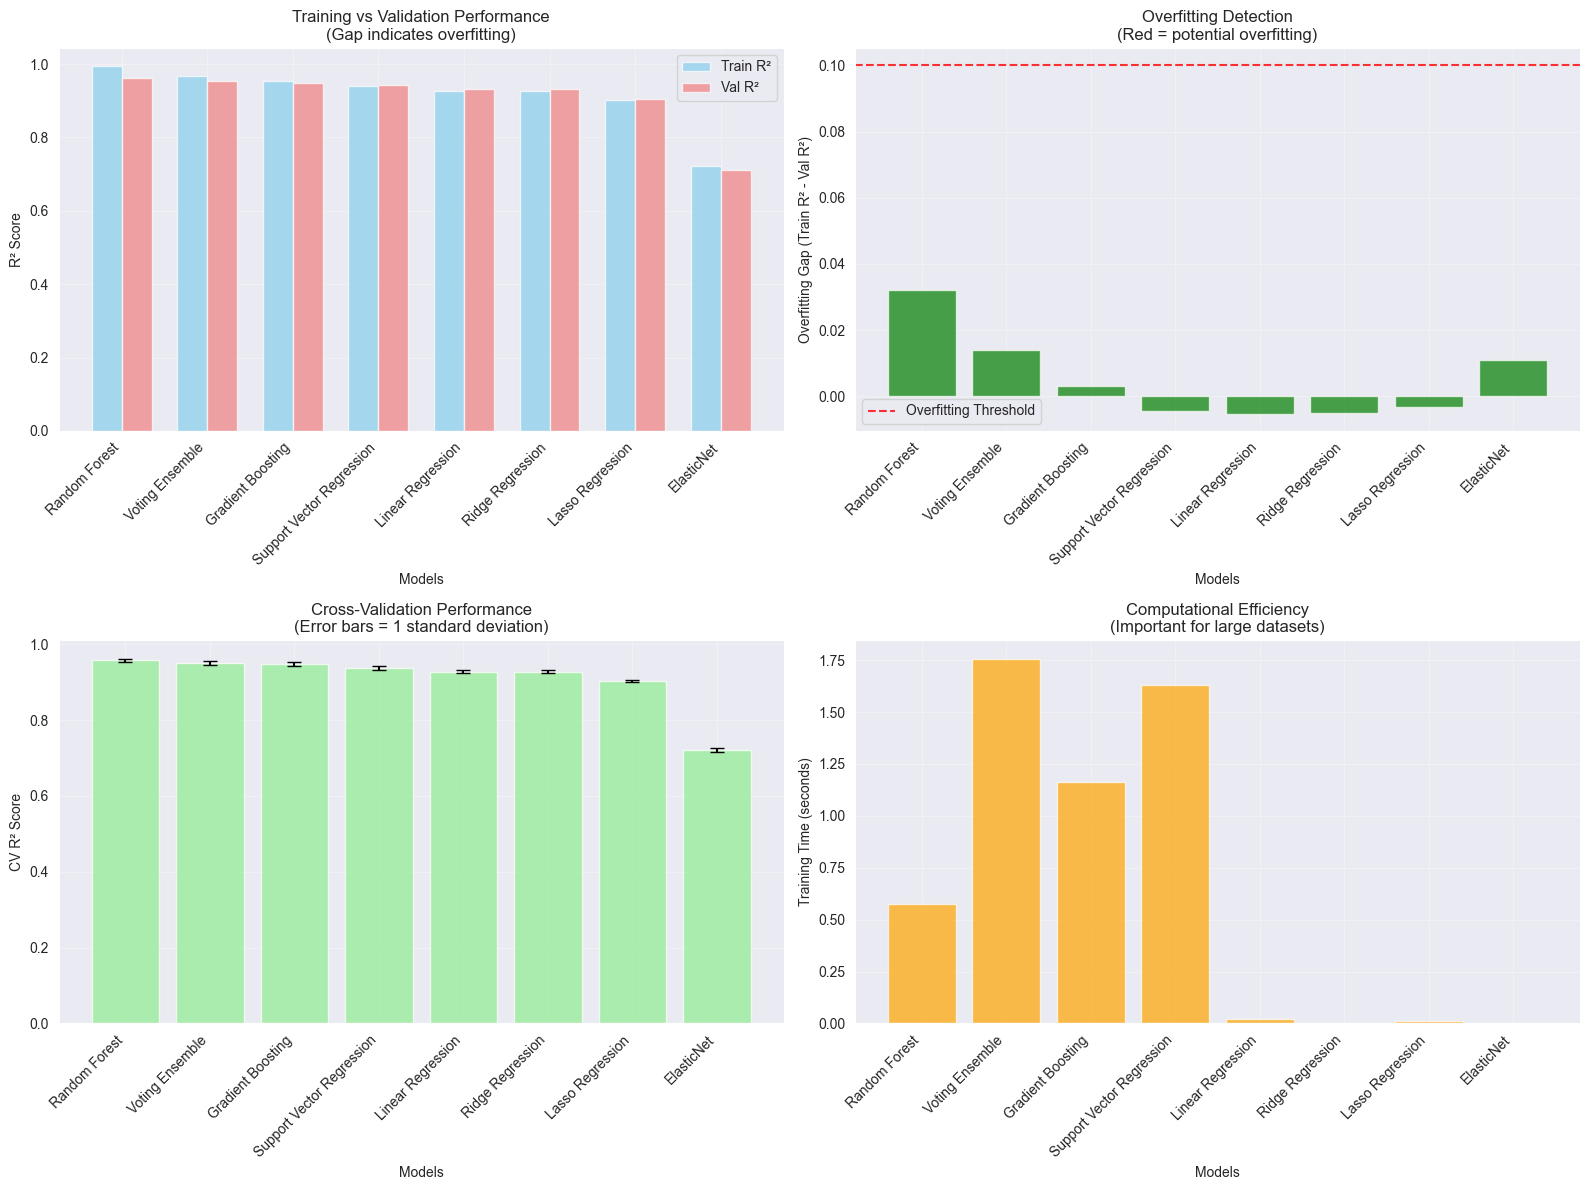


🎯 BEST MODEL SELECTED: Random Forest
📊 Validation R²: 0.9620
🔍 CV R²: 0.9574 ± 0.0045

💡 INTERPRETATION GUIDE:
• Good: High R², small train-val gap, stable CV, reasonable training time
• Overfitting: Large gap between train and validation performance
• Unstable: Large CV standard deviation
• Best choice: Balances performance, stability, and efficiency


In [21]:
# 📈 CELL 7: Advanced Model Comparison Visualization
print("📈 ADVANCED MODEL COMPARISON")

# Create comprehensive results dataframe
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values('val_r2', ascending=False)

print("\n" + "=" * 80)
print("🏆 MODEL PERFORMANCE RANKING")
print("=" * 80)
print(f"{'Model':<25} {'Val R²':<8} {'CV R²':<12} {'Overfitting':<12} {'Time (s)':<10}")
print("-" * 80)

for model_name in results_df.index:
    row = results_df.loc[model_name]
    overfitting_indicator = "⚠️" if row['overfitting_gap'] > 0.1 else "✅"
    print(f"{model_name:<25} {row['val_r2']:>7.4f} {row['cv_r2_mean']:>7.4f} ± {row['cv_r2_std']:>5.4f} "
          f"{overfitting_indicator:>3} {row['overfitting_gap']:>7.4f} {row['training_time']:>9.2f}")

# Comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. R² Comparison
models_ordered = results_df.index
val_r2 = [results[model]['val_r2'] for model in models_ordered]
train_r2 = [results[model]['train_r2'] for model in models_ordered]

x = np.arange(len(models_ordered))
width = 0.35

axes[0, 0].bar(x - width/2, train_r2, width, label='Train R²', alpha=0.7, color='skyblue')
axes[0, 0].bar(x + width/2, val_r2, width, label='Val R²', alpha=0.7, color='lightcoral')
axes[0, 0].set_xlabel('Models')
axes[0, 0].set_ylabel('R² Score')
axes[0, 0].set_title('Training vs Validation Performance\n(Gap indicates overfitting)')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(models_ordered, rotation=45, ha='right')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Overfitting Analysis
overfitting_gaps = [results[model]['overfitting_gap'] for model in models_ordered]
colors = ['red' if gap > 0.1 else 'green' for gap in overfitting_gaps]
axes[0, 1].bar(models_ordered, overfitting_gaps, color=colors, alpha=0.7)
axes[0, 1].axhline(y=0.1, color='red', linestyle='--', alpha=0.8, label='Overfitting Threshold')
axes[0, 1].set_xlabel('Models')
axes[0, 1].set_ylabel('Overfitting Gap (Train R² - Val R²)')
axes[0, 1].set_title('Overfitting Detection\n(Red = potential overfitting)')
axes[0, 1].set_xticklabels(models_ordered, rotation=45, ha='right')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Cross-Validation Stability
cv_means = [results[model]['cv_r2_mean'] for model in models_ordered]
cv_stds = [results[model]['cv_r2_std'] for model in models_ordered]
axes[1, 0].bar(models_ordered, cv_means, yerr=cv_stds, capsize=5, alpha=0.7, color='lightgreen')
axes[1, 0].set_xlabel('Models')
axes[1, 0].set_ylabel('CV R² Score')
axes[1, 0].set_title('Cross-Validation Performance\n(Error bars = 1 standard deviation)')
axes[1, 0].set_xticklabels(models_ordered, rotation=45, ha='right')
axes[1, 0].grid(True, alpha=0.3)

# 4. Computational Efficiency
training_times = [results[model]['training_time'] for model in models_ordered]
axes[1, 1].bar(models_ordered, training_times, alpha=0.7, color='orange')
axes[1, 1].set_xlabel('Models')
axes[1, 1].set_ylabel('Training Time (seconds)')
axes[1, 1].set_title('Computational Efficiency\n(Important for large datasets)')
axes[1, 1].set_xticklabels(models_ordered, rotation=45, ha='right')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Select best model
best_model_name = results_df.index[0]
best_model = trained_models[best_model_name]
print(f"\n🎯 BEST MODEL SELECTED: {best_model_name}")
print(f"📊 Validation R²: {results_df.iloc[0]['val_r2']:.4f}")
print(f"🔍 CV R²: {results_df.iloc[0]['cv_r2_mean']:.4f} ± {results_df.iloc[0]['cv_r2_std']:.4f}")

print("\n💡 INTERPRETATION GUIDE:")
print("• Good: High R², small train-val gap, stable CV, reasonable training time")
print("• Overfitting: Large gap between train and validation performance")
print("• Unstable: Large CV standard deviation")
print("• Best choice: Balances performance, stability, and efficiency")

## 🔍 Step 11:⚙️ Advanced Hyperparameter Optimization

Machine learning models have **hyperparameters**—settings that control how the model learns.
Choosing the right hyperparameters can dramatically improve performance.

- **Default parameters** are rarely optimal.
- **Systematic search** (like `RandomizedSearchCV`) explores different combinations efficiently.
- **MLflow tracking** logs all experiments, making it easy to compare results.

In this section, we will tune hyperparameters for several models:
- Random Forest
- Gradient Boosting
- Ridge Regression
- Voting Ensemble

> 🎯 Goal: Find the best configurations that maximize model performance while preventing overfitting.

In [22]:
# Define comprehensive hyperparameter grids
param_grids = {
    'Random Forest': {
        'n_estimators': [50, 100, 200, 300],  # Number of trees
        'max_depth': [None, 10, 20, 30],  # Tree depth
        'min_samples_split': [2, 5, 10],  # Minimum samples to split
        'min_samples_leaf': [1, 2, 4],  # Minimum samples per leaf
        'max_features': ['auto', 'sqrt', 'log2']  # Features to consider for splits
    },

    'Gradient Boosting': {
        'n_estimators': [50, 100, 200],  # Number of boosting stages
        'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Step size shrinkage
        'max_depth': [3, 4, 5, 6],  # Maximum depth per tree
        'min_samples_split': [2, 5, 10],  # Minimum samples to split
        'subsample': [0.8, 0.9, 1.0]  # Fraction of samples for fitting
    },

    'Ridge Regression': {
        'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0],  # Regularization strength
        'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']  # Algorithm
    },

    'Voting Ensemble': {
        'ridge__alpha': [0.1, 1.0, 10.0],
        'rf__n_estimators': [50, 100],
        'rf__max_depth': [10, 20],
        'gb__n_estimators': [50, 100],
        'gb__learning_rate': [0.05, 0.1]
    }
}

### 📝 Steps: Hyperparameter Optimization

1. **Initialize storage**
   - `tuned_models` will store the best model for each algorithm.
   - `optimization_results` will store the best score and parameters for each model.

2. **Loop over each model**
   - Models: Random Forest, Gradient Boosting, Ridge Regression, Voting Ensemble.

3. **Start MLflow tracking**
   - Each model tuning run is logged with `mlflow.start_run(run_name=model_name_tuned)`.

4. **Run RandomizedSearchCV**
   - Tries `n_iter=20` random combinations from the model’s hyperparameter grid.
   - Uses cross-validation (`cv=config.CV_FOLDS`) to estimate performance.
   - Scores models using R² (`scoring='r2'`).

5. **Fit the search**
   - Fits the model on the training data and finds the best hyperparameters.

6. **Store best results**
   - Best model saved in `tuned_models`.
   - Best score and parameters saved in `optimization_results`.

7. **Log everything to MLflow**
   - Hyperparameters, best cross-validation score, and the tuned model artifact.

8. **Print summary**
   - Shows best CV R² and the parameters found for each model.

**⚠️⚠️This code bellow will take more time to run⚠️⚠️**

> 🎯 Goal: Automatically find the best hyperparameter settings to maximize model performance while keeping tracking and reproducibility simple.

In [23]:
# Perform hyperparameter optimization
print("🎯 STARTING HYPERPARAMETER OPTIMIZATION...")
tuned_models = {}
optimization_results = {}

for model_name in ['Random Forest', 'Gradient Boosting', 'Ridge Regression', 'Voting Ensemble']:
    print(f"\n🔧 Tuning {model_name}...")

    with mlflow.start_run(run_name=f"{model_name}_tuned"):
        # Use RandomizedSearchCV for efficient optimization
        search = RandomizedSearchCV(
            advanced_models[model_name],
            param_grids[model_name],
            n_iter=20,  # Try 20 random combinations (efficient!)
            cv=config.CV_FOLDS,
            scoring='r2',
            n_jobs=config.N_JOBS,
            random_state=config.RANDOM_STATE,
            verbose=1
        )

        # Perform the search
        search.fit(X_train, Y_train)

        # Store results
        tuned_models[model_name] = search.best_estimator_
        optimization_results[model_name] = {
            'best_score': search.best_score_,
            'best_params': search.best_params_,
            'best_estimator': search.best_estimator_
        }

        # Log to MLflow
        mlflow.log_params(search.best_params_)
        mlflow.log_metric('best_cv_score', search.best_score_)
        mlflow.sklearn.log_model(search.best_estimator_, "tuned_model")

        print(f"✅ {model_name:20} | Best CV R²: {search.best_score_:.4f}")
        print(f"   Best parameters found: {search.best_params_}")

print(f"\n🎉 HYPERPARAMETER OPTIMIZATION COMPLETE!")
print(f"💡 All tuned models saved in MLflow for comparison")

🎯 STARTING HYPERPARAMETER OPTIMIZATION...

🔧 Tuning Random Forest...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


2026/01/09 15:09:06 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/09 15:09:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Random Forest        | Best CV R²: 0.9600
   Best parameters found: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None}

🔧 Tuning Gradient Boosting...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


2026/01/09 15:09:24 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/09 15:09:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Gradient Boosting    | Best CV R²: 0.9593
   Best parameters found: {'subsample': 1.0, 'n_estimators': 100, 'min_samples_split': 5, 'max_depth': 5, 'learning_rate': 0.2}

🔧 Tuning Ridge Regression...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


2026/01/09 15:09:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/09 15:09:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Ridge Regression     | Best CV R²: 0.9278
   Best parameters found: {'solver': 'saga', 'alpha': 0.01}

🔧 Tuning Voting Ensemble...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


2026/01/09 15:10:03 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/09 15:10:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Voting Ensemble      | Best CV R²: 0.9509
   Best parameters found: {'ridge__alpha': 0.1, 'rf__n_estimators': 100, 'rf__max_depth': 20, 'gb__n_estimators': 100, 'gb__learning_rate': 0.1}

🎉 HYPERPARAMETER OPTIMIZATION COMPLETE!
💡 All tuned models saved in MLflow for comparison


📊 Tuned Models Performance:


,Model,Best CV R²
0,Random Forest,0.960029
1,Gradient Boosting,0.959288
2,Ridge Regression,0.927820
3,Voting Ensemble,0.950874


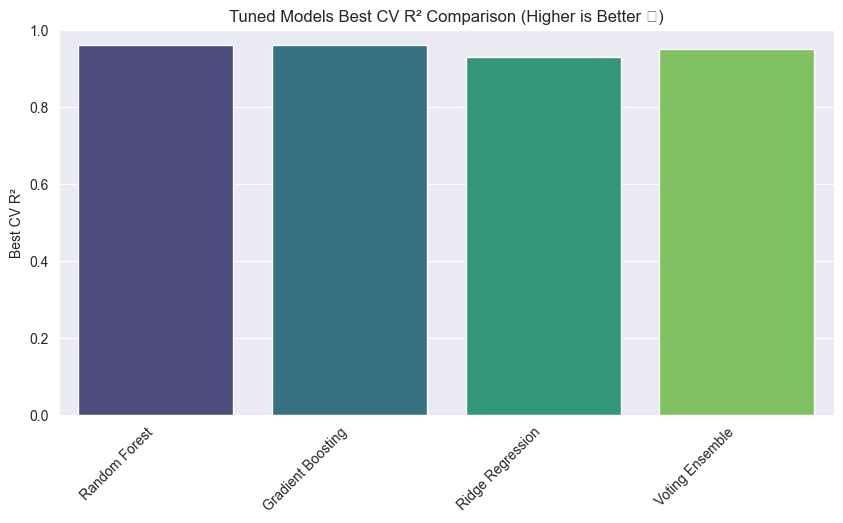

In [24]:
# ===========================
# 1️⃣ Convert optimization results to DataFrame
# ===========================
tuned_metrics_df = pd.DataFrame.from_dict({
    model: {
        'Best CV R²': optimization_results[model]['best_score']
    } for model in optimization_results
}, orient='index').reset_index().rename(columns={'index': 'Model'})

print("📊 Tuned Models Performance:")
display(tuned_metrics_df)

# ===========================
# 2️⃣ Plot Best CV R² (Higher is better)
# ===========================
plt.figure(figsize=(10,5))
sns.barplot(data=tuned_metrics_df, x='Model', y='Best CV R²', palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.title('Tuned Models Best CV R² Comparison (Higher is Better ✅)')
plt.ylabel('Best CV R²')
plt.xlabel('')
plt.ylim(0,1)
plt.show()

# A more sophisticated version of the previous visualization

Model                Untuned R²   Tuned R²     Improvement 
------------------------------------------------------------
Random Forest            0.9620     0.9642 📈   0.0021
Gradient Boosting        0.9497     0.9623 📈   0.0125
Ridge Regression         0.9331     0.9331 📈   0.0000
Voting Ensemble          0.9547     0.9547 📉  -0.0000


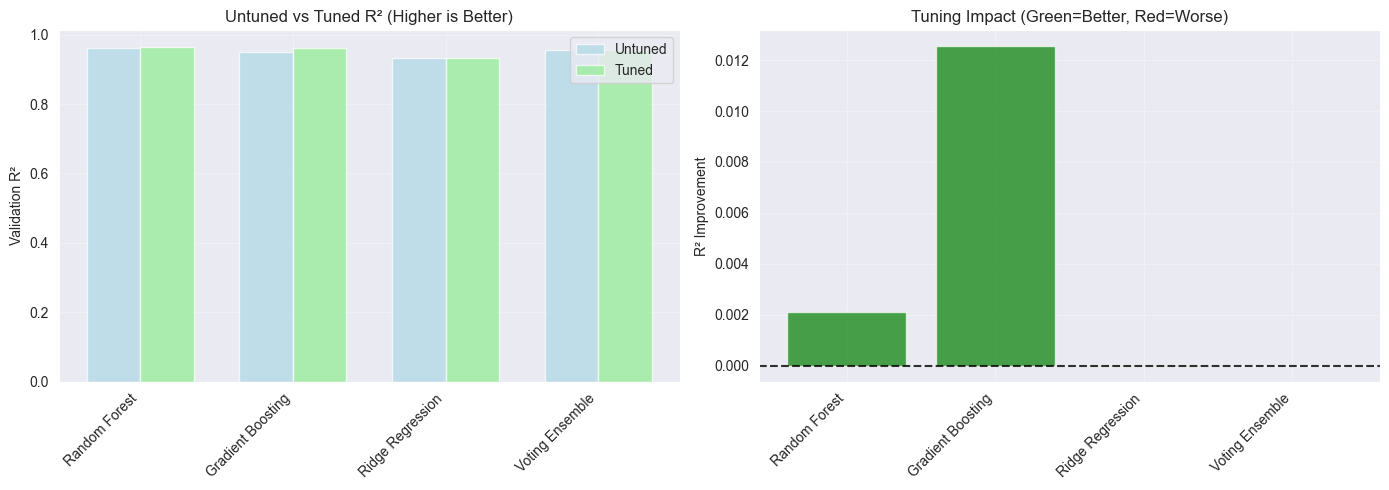


🏆 BEST TUNED MODEL: Random Forest
📊 Validation R²: 0.9642
📈 Improvement over untuned: +0.0021


In [25]:
# ===========================
# 1️⃣ Evaluate tuned models on validation set
# ===========================
tuned_results = {}
for model_name, tuned_model in tuned_models.items():
    y_val_pred = tuned_model.predict(X_val)
    val_r2 = r2_score(Y_val, y_val_pred)
    val_rmse = np.sqrt(mean_squared_error(Y_val, y_val_pred))
    improvement = val_r2 - results[model_name]['val_r2']  # vs untuned

    tuned_results[model_name] = {
        'val_r2': val_r2,
        'val_rmse': val_rmse,
        'improvement': improvement
    }

# ===========================
# 2️⃣ Print simple comparison table
# ===========================
print(f"{'Model':<20} {'Untuned R²':<12} {'Tuned R²':<12} {'Improvement':<12}")
print("-" * 60)
for model_name, res in tuned_results.items():
    untuned_r2 = results[model_name]['val_r2']
    tuned_r2 = res['val_r2']
    improvement = res['improvement']
    icon = "📈" if improvement > 0 else "📉" if improvement < 0 else "➡️"
    print(f"{model_name:<20} {untuned_r2:>10.4f} {tuned_r2:>10.4f} {icon} {improvement:>8.4f}")

# ===========================
# 3️⃣ Plot Tuned vs Untuned R²
# ===========================
models = list(tuned_results.keys())
untuned_r2 = [results[m]['val_r2'] for m in models]
tuned_r2 = [tuned_results[m]['val_r2'] for m in models]
improvement = [tuned_results[m]['improvement'] for m in models]

x = np.arange(len(models))
width = 0.35

fig, axes = plt.subplots(1, 2, figsize=(14,5))

# R² comparison
axes[0].bar(x - width/2, untuned_r2, width, label='Untuned', alpha=0.7, color='lightblue')
axes[0].bar(x + width/2, tuned_r2, width, label='Tuned', alpha=0.7, color='lightgreen')
axes[0].set_xticks(x)
axes[0].set_xticklabels(models, rotation=45, ha='right')
axes[0].set_ylabel('Validation R²')
axes[0].set_title('Untuned vs Tuned R² (Higher is Better)')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Improvement plot
colors = ['green' if i>0 else 'red' for i in improvement]
axes[1].bar(models, improvement, color=colors, alpha=0.7)
axes[1].axhline(0, color='black', linestyle='--', alpha=0.8)
axes[1].set_ylabel('R² Improvement')
axes[1].set_title('Tuning Impact (Green=Better, Red=Worse)')
axes[1].set_xticklabels(models, rotation=45, ha='right')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# ===========================
# 4️⃣ Best tuned model
# ===========================
best_model_name = max(tuned_results, key=lambda m: tuned_results[m]['val_r2'])
print(f"\n🏆 BEST TUNED MODEL: {best_model_name}")
print(f"📊 Validation R²: {tuned_results[best_model_name]['val_r2']:.4f}")
print(f"📈 Improvement over untuned: +{tuned_results[best_model_name]['improvement']:.4f}")

## 🔍 Step 12:✅ Final Test Set Evaluation
To ensure our selected best model is not overfitting and truly generalizes,we perform a final evaluation on the held-out test set.
This step provides an unbiased estimate of how the model will perform on unseen data, which is a standard and critical practice in machine learning before deploying a model to production.

In [26]:
best_tuned_model = tuned_models[best_model_name]
Y_test_pred = best_tuned_model.predict(X_test)
test_r2 = r2_score(Y_test, Y_test_pred)
test_rmse = np.sqrt(mean_squared_error(Y_test, Y_test_pred))
test_mae = mean_absolute_error(Y_test, Y_test_pred)

print(f"📊 Test R²: {test_r2:.4f}")
print(f"📊 Test RMSE: {test_rmse:.4f}")
print(f"📊 Test MAE: {test_mae:.4f}")

📊 Test R²: 0.9668
📊 Test RMSE: 3.0378
📊 Test MAE: 2.2161


## 🔍 Step 13: 🚀 Model Deployment Preparation
Now that we have selected the best tuned model and confirmed it generalizes well on the validation (and test) data, we can prepare it for deployment.

# This involves several important steps:
1️⃣ Identify the best model based on validation performance.

2️⃣ Version the model and save both the trained model and preprocessing pipeline.

3️⃣ Create a comprehensive model card containing metadata, performance metrics, data information, model configuration, preprocessing steps, and deployment instructions.

4️⃣ Save deployment requirements to ensure reproducibility in production.

These steps ensure that the model is production-ready and can be deployed (e.g., via Streamlit) in a consistent, versioned, and well-documented manner.

In [27]:
# ===========================
# 0️⃣ Prepare feature names
# ===========================
# Works for both DataFrame and NumPy array
try:
    feature_names_all = list(X.columns)
except AttributeError:
    feature_names_all = [f"feature_{i}" for i in range(X.shape[1])]

# ===========================
# 1️⃣ Identify best tuned model
# ===========================
best_model_name = max(tuned_results, key=lambda m: tuned_results[m]['val_r2'])
best_tuned_model = tuned_models[best_model_name]

print(f"🏆 BEST TUNED MODEL: {best_model_name}")
print(f"📊 Validation R²: {tuned_results[best_model_name]['val_r2']:.4f}")
print(f"📈 Improvement over untuned: +{tuned_results[best_model_name]['improvement']:.4f}")

# ===========================
# 2️⃣ Evaluate on Test Set
# ===========================
Y_test_pred = best_tuned_model.predict(X_test)
test_r2 = r2_score(Y_test, Y_test_pred)
test_rmse = np.sqrt(mean_squared_error(Y_test, Y_test_pred))
test_mae = mean_absolute_error(Y_test, Y_test_pred)

print(f"\n📊 Test Set Performance:")
print(f"R²: {test_r2:.4f} | RMSE: {test_rmse:.4f} | MAE: {test_mae:.4f}")

# ===========================
# 3️⃣ Versioning and saving
# ===========================
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_version = f"v1_{timestamp}"
model_save_dir = os.path.join(config.MODEL_DIR, model_version)
os.makedirs(model_save_dir, exist_ok=True)

# Save model
model_path = os.path.join(model_save_dir, 'best_model.pkl')
joblib.dump(best_tuned_model, model_path)
print(f"✅ Model saved: {model_path}")

# Save preprocessing pipeline
preprocessor_path = os.path.join(model_save_dir, 'preprocessor.pkl')
joblib.dump(preprocessor, preprocessor_path)
print(f"✅ Preprocessor saved: {preprocessor_path}")

# ===========================
# 4️⃣ Create model card
# ===========================
model_card = {
    'model_name': best_model_name,
    'model_version': model_version,
    'timestamp': timestamp,
    'dataset': 'California Housing',
    'target': 'House Price ($M)',

    'performance': {
        'test_r2': float(test_r2),
        'test_rmse': float(test_rmse),
        'test_mae': float(test_mae),
        'train_r2': float(results[best_model_name]['train_r2']),
        'val_r2': float(tuned_results[best_model_name]['val_r2']),
        'cv_r2_mean': float(results[best_model_name]['cv_r2_mean']),
        'cv_r2_std': float(results[best_model_name]['cv_r2_std']),
    },

    'data_info': {
        'total_samples': int(len(X)),
        'train_samples': int(len(X_train)),
        'val_samples': int(len(X_val)),
        'test_samples': int(len(X_test)),
        'n_features': X_test.shape[1],
        'feature_names': feature_names_all,
    },

    'model_config': {
        'model_class': best_model_name,
        'hyperparameters': dict(best_tuned_model.get_params())
        if hasattr(best_tuned_model, 'get_params') else {},
    },

    'preprocessing': {
        'steps': [
            'AdvancedFeatureEngineering (6 new features)',
            'OutlierHandling (IQR method)',
            'RobustScaler (outlier-resistant scaling)',
        ],
        'outlier_factor': 1.5,
    },

    'deployment': {
        'status': 'Ready for Production',
        'recommendations': [
            'Monitor prediction errors in production',
            'Retrain quarterly with new data',
            'Alert if RMSE exceeds $0.50M',
        ]
    }
}

card_path = os.path.join(model_save_dir, 'model_card.json')
with open(card_path, 'w') as f:
    json.dump(model_card, f, indent=2)
print(f"✅ Model card saved: {card_path}")

# ===========================
# 5️⃣ Deployment requirements
# ===========================
requirements = {
    'python': '3.8+',
    'packages': {
        'scikit-learn': '1.0+',
        'numpy': '1.20+',
        'pandas': '1.3+',
        'joblib': '1.0+',
    }
}

req_path = os.path.join(model_save_dir, 'requirements.json')
with open(req_path, 'w') as f:
    json.dump(requirements, f, indent=2)
print(f"✅ Deployment requirements saved: {req_path}")

# ===========================
# 6️⃣ Summary
# ===========================
print("\n💾 DEPLOYMENT PACKAGE READY")
print(f"Location: {model_save_dir}")


joblib.dump(Pipeline, "../best_model.pkl")

🏆 BEST TUNED MODEL: Random Forest
📊 Validation R²: 0.9642
📈 Improvement over untuned: +0.0021

📊 Test Set Performance:
R²: 0.9668 | RMSE: 3.0378 | MAE: 2.2161
✅ Model saved: ../models\v1_20260109_152722\best_model.pkl
✅ Preprocessor saved: ../models\v1_20260109_152722\preprocessor.pkl
✅ Model card saved: ../models\v1_20260109_152722\model_card.json
✅ Deployment requirements saved: ../models\v1_20260109_152722\requirements.json

💾 DEPLOYMENT PACKAGE READY
Location: ../models\v1_20260109_152722


['../best_model.pkl']

## 🚀Final Step: Interactive Prediction UI with Streamlit

After completing model training, evaluation, versioning, and saving all artifacts (model, preprocessor, model card, and requirements), the **final step** is to create a **user-friendly interface** for making predictions in real time.

### Why Streamlit?

- **Streamlit vs Gradio**:
  - Both are great for building quick ML UIs, but **Streamlit** offers more flexibility for dashboards, multi-page apps, and complex layouts.
  - Streamlit is widely adopted in industry for **production-ready applications**, whereas Gradio is often used for simple demos and prototyping.

- **Motivation**:
  - Allow non-technical users to input house features interactively.
  - Make real-time predictions using the trained pipeline.
  - Visualize inputs and outputs for better interpretability.

### Implementation

  1. **`app.py`**
     - Main Streamlit script for the dashboard.
     - Loads the latest model and preprocessor.
     - Accepts user input via sliders, runs predictions, and displays results.

  2. **`utils.py`** *(helper module)*
     - Contains reusable utility functions such as feature preprocessing, input validation, and prediction wrappers.

By completing this step, the project now covers the **full ML lifecycle**: from raw data exploration → advanced feature engineering → model training → hyperparameter tuning → model versioning → deployment-ready interactive UI.
